# 08 - Linear regression

This notebook contains solution proposals to the home exercises.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

import statsmodels.formula.api as smf
from itertools import combinations

plt.style.use('seaborn-v0_8-whitegrid')

### 📚 Exercise 1: Outliers in hourly earnings

The file `survey_data.csv` contains information on the hourly earnings (in DKK) of 2,884 respondents. In statistical analysis, the presence of outliers (i.e., extreme values) can have a large impact on the results of the estimation and how well the model predicts the observed outcome. Therefore, in this exercise, you will investigate the presence of outliers in the survey data and its effect on the estimates from a linear regression model.

**Task 1**: Load the data and do the following:
- Calculate the number of respondents that had an hourly wage of less than 10 DKK or above 1000 DKK.
- Calculate the average hourly wage for males and females in the private and public sector.
- Create a single plot that shows histograms of the hourly earnings for males and females seperately.

In [2]:
df_wage = pd.read_csv('data/survey_data.csv', sep = ':')

print(len(df_wage))
df_wage.head()

2884


,respondentID,age,hourly_earnings,years_schooling,sex,sector,experience
0,1,50,109.357913,9,male,private,30
1,2,50,267.671518,15,male,public,26
2,3,46,193.239479,15,female,public,29
3,4,41,206.217778,12,male,private,24
4,5,39,159.350102,12,female,private,19


In [3]:
# Check data types
# df_wage.info()

In [4]:
# Check missing values
# df_wage.isna().sum()

In [5]:
# Check respondent with unusually low or high hourly earnings
df_wage[(df_wage['hourly_earnings'] < 10) | (df_wage['hourly_earnings'] > 1000)]

,respondentID,age,hourly_earnings,years_schooling,sex,sector,experience
64,65,51,1153.846154,17,male,private,26
498,499,60,1153.846154,15,male,private,36
1173,1174,60,4479.768786,15,female,public,40
1373,1374,49,1373.901099,17,male,private,31
1923,1924,40,0.000469,15,male,private,18
2065,2066,37,1017.341040,12,female,private,15
2733,2734,59,1156.069364,12,male,private,42


In [6]:
print(len(df_wage[(df_wage['hourly_earnings'] < 10) | (df_wage['hourly_earnings'] > 1000)]))

7


In [7]:
# Calculate average hourly earnings by sex and sector
df_wage.groupby(['sex', 'sector'])['hourly_earnings'].mean()

sex     sector 
female  private    209.596023
        public     194.285809
male    private    234.369391
        public     214.146227
Name: hourly_earnings, dtype: float64

In [8]:
# Extract males and females
males = df_wage[df_wage['sex'] == 'male'].copy()
females = df_wage[df_wage['sex'] == 'female'].copy()

print('Number of males: {}'.format(len(males)))
print('Number of females: {}'.format(len(females)))

Number of males: 1378
Number of females: 1506


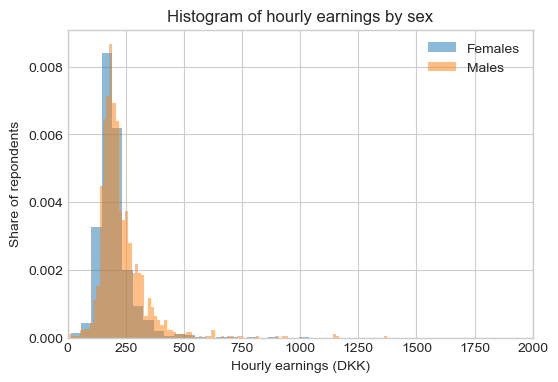

In [9]:
fig, ax = plt.subplots(figsize = (6, 4))

# Historgram: females
ax.hist(
    females['hourly_earnings'], 
    bins = 100, 
    alpha = 0.5, # increase transparency
    label = 'Females',
    density = True
)      

# Historgram: males
ax.hist(
    males['hourly_earnings'], 
    bins = 100, 
    alpha = 0.5, # increase transparency
    label = 'Males',
    density = True
)     

# Formatting
ax.set_xlabel('Hourly earnings (DKK)')
ax.set_ylabel('Share of repondents')
ax.set_title('Histogram of hourly earnings by sex')
ax.set_xlim(0, 2000) # remove outliers from histogram
ax.legend()

plt.show()

**Task 2**: Create a function called `get_beta` that estimates a regression model and returns the beta coefficient for a specific explanatory variable. The function should take three inputs: `df` (the dataset), `formula` (formula for the regression model), and `exp` (column name of an explanatory variable). 

Test the function by estimating the following regression model

$hourly\_earnings_i = \alpha + \beta_1 \times years\_schooling_i + \beta_2 \times experience_i + \beta_3 \times experience_i^2$,

and print the $\beta$-coefficient on the number of years of schooling.

In [10]:
def get_beta(df, formula, exp):
    """Estimate linear regression model and return beta coefficient on an explanatory variable"""

    # Create and fit OLS model
    mod = smf.ols(formula, data = df).fit()
        
    # Return beta coefficient
    return mod.params[exp]

In [11]:
# Define formula
f = 'hourly_earnings ~ years_schooling + experience + I(experience**2)'

# Drop respondents (i.e., rows) in case there are missing values
df_wage2 = df_wage.dropna(subset = ['hourly_earnings', 'years_schooling', 'experience'], axis = 0)

# Print beta coefficient on years of schooling
xvar = 'years_schooling'
coef = get_beta(df_wage2, f, xvar)
print(f'One additional year of schooling is associated with a {coef:.2f} DKK change in hourly earnings.')

One additional year of schooling is associated with a 13.77 DKK change in hourly earnings.


**Task 3**: There are some respondents in the data that have an extremely high or low hourly wage. We want to explore how much dropping a single observation, i.e., respondent, from our data affects the estimated coefficient on years of schooling in the regression model from the previous task. 

1. Write a `for` loop where you in each iteration:
    - drop an observation from the data
    - use `get_beta` to retrieve the coefficient on years of schooling
    - store the coefficient in a list
   
   *Note*: In the first iteration you should drop the first respondent from the data. In the second iteration you should keep the first respondent but drop the second respondent. In the third iteration you should keep the first and second respondents, but drop the third one, and so on...

In [12]:
# Empty list to store beta coefficients
coef_lst = []

for i in df_wage2['respondentID'].unique():
    
    # Drop respondent i from sample
    df_temp = df_wage2.loc[df_wage2['respondentID'] != i]
    
    # Get beta coefficent
    coef = get_beta(df_temp, f, xvar)
    
    # Append to list
    coef_lst.append(coef)

print(len(coef_lst))

2884


In [13]:
print(max(coef_lst))
print(min(coef_lst))
print(np.mean(coef_lst))

13.887263047973514
13.24084206406487
13.767279667652318


2. Use the list with the estimated coefficients on years of schooling from the previous task and display the distribution of the coefficients in a histogram. What is your verdict? Does it seem that the $\beta$ coefficient on `years_schooling` is affected by the presence of outliers?

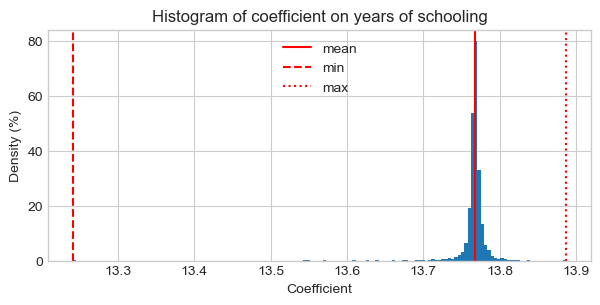

In [14]:
fig, ax = plt.subplots(figsize = (7, 3))

# Histogram of coefficients
ax.hist(coef_lst, bins = 150, density = True)

# Add vertical lines
ax.axvline(np.mean(coef_lst), color = 'red', linestyle = '-', label = 'mean')
ax.axvline(min(coef_lst), color = 'red', linestyle = '--', label = 'min')
ax.axvline(max(coef_lst), color = 'red', linestyle = ':', label = 'max')

# Formatting
ax.set_xlabel('Coefficient')
ax.set_ylabel('Density (%)')
ax.set_title('Histogram of coefficient on years of schooling')
ax.legend(loc = 'upper center')

plt.show()

Conclusion: The presence of outliers, i.e., respondents with unusually high or low hourly earnings does not seem to affect the estimated beta coefficient on the years of schooling too much. 

### 📚 Exercise 2: Fuel economy and polynomials

We have estimated a 2nd order polynomial model in which we used the number of horsepower to explain variation in fuel economy. However, there could also be a non-linear relationship between fuel economy and other car attributes. Including polynomial terms can often improve the explanatory power of our regression models. Therefore, in this exercise, you will explore the adjusted R-squared from using different car attributes in a 2nd order polynomial model.


**Task 1**: Create a function called `get_rsqr` that estimates a regression model and returns the model's adjusted R-squared. The function should take two inputs: `df` (the dataset) and `formula` (formula for the regression model). Import the `mpg` data and test the function by estimating the model

$mpg_i = \alpha + \beta_1 \times horsepower_i + \beta_2 \times horsepower_i^2$,

and print the adjusted R-square from the model.

In [15]:
def get_rsqr(df, formula):
    """Estimate a linear regression model and return the adj. R-squared from the model."""
    
    # Create and fit an OLS model
    model = smf.ols(formula, data = df).fit()
    
    # Store adj. R-squared
    rsqr = model.rsquared_adj
    
    return rsqr

In [16]:
# Import mpg data
mpg_df = pd.read_excel('data/mpg.xlsx')

print(len(mpg_df))
mpg_df.head()

398


,mpg,cylinders,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,140.0,3449,10.5,70,usa,ford torino


In [17]:
# Check missing values
# mpg_df.isna().sum()

In [18]:
# Define formula
f = 'mpg ~ horsepower + I(horsepower**2)'

# Drop car models (i.e., rows) in case there are missing values
mpg_df2 = mpg_df.dropna(subset = ['mpg', 'horsepower'], axis = 0)

# Print adj. R-squared from model
rsqr = get_rsqr(mpg_df2, f)
print(f'Adjusted R-squared from model: {rsqr:.3f}')

Adjusted R-squared from model: 0.686


**Task 2**: We now want to compare the adjusted R-squared from the 2nd order polynomial model in the previous task, but using four different car attributes: `horsepower`, `weight`, `acceleration` and `model_year`. 

Write a `for` loop where you in each iteration:
- Update the model formula for the polynomial model to include one of the four car attributes
- Use the function `get_rsqr` to get the adjusted R-squared from the model.
- Print the adjusted R-squared from each of the polynomial models
    
*Note*: In each iteration, the polynomial model should include only one car attribute. In the first iteration, the model should use `horsepower`; in the second iteration, the model should use `weight`; and so on.

Which 2nd order polynomial model has the highest adj. R-squared?

In [19]:
xvars = ['horsepower', 'weight', 'acceleration', 'model_year']

for xvar in xvars:

    # Update model formula
    f = 'mpg ~ ' + xvar + ' + I(' + xvar + '**2)'

    # Estimate model and get adj. R-squared
    df_temp = mpg_df.dropna(subset = ['mpg', xvar], axis = 0)
    rsqr = get_rsqr(df_temp, f)

    print(f'Model: {f}')
    print(f'... Adjusted R-squred: {rsqr:.3f}\n')

Model: mpg ~ horsepower + I(horsepower**2)
... Adjusted R-squred: 0.686

Model: mpg ~ weight + I(weight**2)
... Adjusted R-squred: 0.713

Model: mpg ~ acceleration + I(acceleration**2)
... Adjusted R-squred: 0.189

Model: mpg ~ model_year + I(model_year**2)
... Adjusted R-squred: 0.362



Conclusion: The model with the highest explanatory power is the 2nd order polynomial model with weight.

**Task 3**: In addition to comparing the adjusted R-squared, we also want to inspect the estimated regression line from each of the polynomial models with the four different car attributes: `horsepower`, `weight`, `acceleration` and `model_year`. 

Create a single graph with four subplots side-by-side (1x4). In each subplot:
- Show a scatter plot with one of the car attributes on the $x$-axis and `mpg` on the $y$-axis.
- Show the regression line using the in-sample predictions from the polynomial model with the car attrbitue
- Add the adjusted R-squared from the polynomial model in the title of the sub-plot

*Hint*: Use a `for` loop to iterate over the axes object to avoid duplicating the code for generating each subplot. Note also that you can use the function `get_predictions` from the lecture to get a `DataFrame` with the in-sample predictions for each polynomial model.

In [20]:
def get_predictions(formula, df):
    """Fit a linear regression model given a model formula and return df with in-sample predictions."""
    
    # Copy dataframe (important! Otherwise, we change the original df)
    df_copy = df.copy()
    
    # Create and fit OLS model
    model = smf.ols(formula, data = df_copy).fit()

    # Add predictions to copied dataframe
    df_copy['pred'] = model.predict(df_copy)
    
    return df_copy

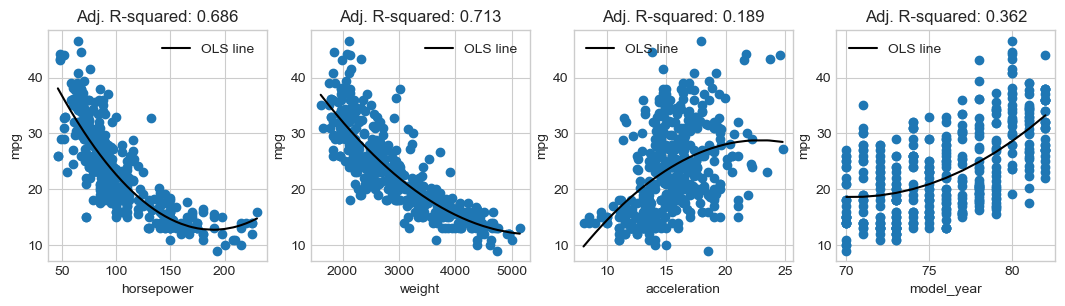

In [21]:
# Define list with car attributes
xvars = ['horsepower', 'weight', 'acceleration', 'model_year']

# Create 1x4 figure with scatter plots and regression lines
fig, ax = plt.subplots(ncols = 4, figsize = (13, 3))

for i in range(4):

    # Generate predictions for a specific car attribute
    f = 'mpg ~ ' + xvars[i] + ' + I(' + xvars[i] + '**2)'
    df_temp = get_predictions(f, mpg_df.dropna(subset = ['mpg', xvars[i]], axis = 0))
    df_temp.sort_values(xvars[i], inplace = True)

    # Add R-sqaure from model in title
    rsqr = get_rsqr(df_temp, f)
    ax[i].set_title(f'Adj. R-squared: {rsqr:.3f}')

    # Show scatter plot between mpg and explanatory variable
    ax[i].scatter(df_temp[xvars[i]], df_temp['mpg'])

    # Add regression line from polynomial model
    ax[i].plot(df_temp[xvars[i]], df_temp['pred'], c = 'black', label = 'OLS line')

    # Formatting
    ax[i].set_xlabel(xvars[i])
    ax[i].set_ylabel('mpg')
    ax[i].legend()

plt.show()

### 📚 Exercise 3: Drivers of CO2 emissions

In this exercise, you are asked to explore CO2 emissions around the world, and potential drivers for why some countries have higher emissions than other countries. To do this, you are given two datasets.

The first file `co2_emissions.csv` contains the following country-level data on CO2 emissions in 2021:
- `country`: Country name
- `year`: Year of observation
- `co2_total`: Total carbon dioxide (CO2) emissions (Mt CO2e)
- `population`: Total population

In addition, the file contains data on the following six potential explanatory variables of country-level CO2 emissions: 
- `urban`: Urban population (% of total population)
- `gdp_pc`: GDP per capita (current US$)
- `electricity`: Access to electricity (% of population)
- `agriculture`: Agricultural land (% of land area)
- `nat_resources`: Total natural resources rents (% of GDP)
- `renew_energy`: Renewable energy consumption (% of total final energy consumption)

Note that the emissions dataset contains data not only for countries, but also for aggregates such as "Africa Eastern and Southern" and "Heavily indebted poor countries (HIPC)". 

The second file `country_info.csv` contains information about the countries and aggregates observed in the emissions dataset:
- `name`: Name of the location (country or aggregate)
- `region`: Region of the location
- `incomeLevel`: Income level of the location (e.g., "Low income")

**Task 1**: Create a dataset that contains countries only:

1. Import and merge the two datasets. Explore the merged data, e.g., data types, missing values, unique values etc.

In [22]:
# Import emissions data
df_co2 = pd.read_csv('data/co2_emissions.csv')

# Import location info data
df_info = pd.read_csv('data/country_info.csv')
df_info.rename(columns = {'name' : 'country'}, inplace = True)

# Merge the data
df_co2 = df_co2.merge(df_info, on = 'country', how = 'left')

print(df_co2['country'].nunique())
df_co2.head()

266


,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel
0,Afghanistan,2021,7.9308,40000412.0,26.314000,356.496214,97.700000,58.741548,0.428525,20.0,"Middle East, North Africa, Afghanistan & Pakistan",Low income
1,Africa Eastern and Southern,2021,606.3945,713090928.0,37.393633,1522.393346,48.127211,46.510566,10.056521,NaN,Aggregates,Aggregates
2,Africa Western and Central,2021,249.1554,485920997.0,48.531971,1765.954788,54.368599,41.373999,9.966112,NaN,Aggregates,Aggregates
3,Albania,2021,5.0393,2811666.0,62.969000,6413.282808,100.000000,41.471898,1.442601,41.9,Europe & Central Asia,Upper middle income
4,Algeria,2021,179.7421,44761099.0,74.261000,4160.559267,99.800000,17.330607,22.590270,0.1,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income


In [23]:
# Check: data types (looks good)
# df_co2.info()

In [24]:
# Note: data contains non-countries
df_co2['country'].unique()

array(['Afghanistan', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'British Virgin Islands', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands',
       'Central African Republic', 'Central Europe and the Baltics',
       'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Repub

In [25]:
# Note: several columns contain missing values
df_co2.isna().sum()

country           0
year              0
co2_total        15
population        1
urban             3
gdp_pc            9
electricity       3
agriculture       8
nat_resources    21
renew_energy     54
region            2
incomeLevel       2
dtype: int64

In [26]:
# Note: several unique regions in the data
df_co2['region'].unique()

array(['Middle East, North Africa, Afghanistan & Pakistan', 'Aggregates',
       'Europe & Central Asia', 'East Asia & Pacific',
       'Sub-Saharan Africa ', 'Latin America & Caribbean ', 'South Asia',
       'North America', nan], dtype=object)

In [27]:
# Note: Aggregates can be identified with the region column
# df_co2[(df_co2['region'] == 'Aggregates') | (df_co2['region'].isna())]

2. Drop all observations that are not countries, e.g., "Africa Eastern and Southern" so that the data contains observations for countries only.

In [28]:
# Drop observatons with missing region info
df_co2.dropna(subset = ['region'], inplace = True)

# Drop aggregate regions, i.e. non-countries
df_co2 = df_co2[df_co2['region'] != 'Aggregates'].copy()

print(f'Number of countries: {df_co2['country'].nunique()}')
df_co2.head()

Number of countries: 217


,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel
0,Afghanistan,2021,7.9308,40000412.0,26.314,356.496214,97.7,58.741548,0.428525,20.0,"Middle East, North Africa, Afghanistan & Pakistan",Low income
3,Albania,2021,5.0393,2811666.0,62.969,6413.282808,100.0,41.471898,1.442601,41.9,Europe & Central Asia,Upper middle income
4,Algeria,2021,179.7421,44761099.0,74.261,4160.559267,99.8,17.330607,22.590270,0.1,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income
5,American Samoa,2021,0.0001,49225.0,87.169,15236.160488,NaN,14.500000,0.000000,0.4,East Asia & Pacific,High income
6,Andorra,2021,NaN,78364.0,87.858,42425.699676,100.0,39.906809,0.000000,18.4,Europe & Central Asia,High income


In [29]:
# Check: unique countries (looks good)
# df_co2['country'].unique()

In [30]:
# Check: but still some observations with missing values
df_co2.isna().sum()

country           0
year              0
co2_total        14
population        0
urban             2
gdp_pc            8
electricity       2
agriculture       7
nat_resources    20
renew_energy      5
region            0
incomeLevel       0
dtype: int64

In [31]:
# Check: some countries with missing co2 data
# df_co2[df_co2['co2_total'].isna()]

In [32]:
# Drop countries with missing co2 data (no reason to keep them)
df_co2 = df_co2[df_co2['co2_total'].notna()].copy()

print(df_co2['country'].nunique())
df_co2.head()

203


,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel
0,Afghanistan,2021,7.9308,40000412.0,26.314,356.496214,97.7,58.741548,0.428525,20.0,"Middle East, North Africa, Afghanistan & Pakistan",Low income
3,Albania,2021,5.0393,2811666.0,62.969,6413.282808,100.0,41.471898,1.442601,41.9,Europe & Central Asia,Upper middle income
4,Algeria,2021,179.7421,44761099.0,74.261,4160.559267,99.8,17.330607,22.590270,0.1,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income
5,American Samoa,2021,0.0001,49225.0,87.169,15236.160488,NaN,14.500000,0.000000,0.4,East Asia & Pacific,High income
7,Angola,2021,25.2628,34532429.0,67.460,1925.874661,48.2,36.830833,29.967435,52.9,Sub-Saharan Africa,Lower middle income


3. Create a new column called `co2_pc`, which is the *per capita* CO2 emissions (t CO2e/capita) for each country.
   
   *Hint*: Multiple total CO2 emissions with 1,000,000 to convert from million tons to tons (otherwise, you'll get very small numbers).

In [33]:
# Calculate tons C02 emissions per capita 
# (note: multiply with 1,000,000 to convert from million ton to ton)
df_co2['co2_pc'] = df_co2['co2_total'] * 1000000 / df_co2['population']

df_co2.head()

,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel,co2_pc
0,Afghanistan,2021,7.9308,40000412.0,26.314,356.496214,97.7,58.741548,0.428525,20.0,"Middle East, North Africa, Afghanistan & Pakistan",Low income,0.198268
3,Albania,2021,5.0393,2811666.0,62.969,6413.282808,100.0,41.471898,1.442601,41.9,Europe & Central Asia,Upper middle income,1.792283
4,Algeria,2021,179.7421,44761099.0,74.261,4160.559267,99.8,17.330607,22.590270,0.1,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income,4.015587
5,American Samoa,2021,0.0001,49225.0,87.169,15236.160488,NaN,14.500000,0.000000,0.4,East Asia & Pacific,High income,0.002031
7,Angola,2021,25.2628,34532429.0,67.460,1925.874661,48.2,36.830833,29.967435,52.9,Sub-Saharan Africa,Lower middle income,0.731567


In [34]:
# Check: descriptives
df_co2.describe()

,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,co2_pc
count,203.0,203.000000,2.030000e+02,203.000000,196.000000,202.000000,201.000000,190.000000,203.000000,203.000000
mean,2021.0,181.134611,3.877673e+07,61.457532,17844.413759,86.809901,37.091856,6.859622,29.420690,4.653396
std,0.0,973.810035,1.453976e+08,23.367461,24050.694057,23.459990,22.834498,10.393989,27.620355,7.598854
min,2021.0,0.000000,1.019400e+04,13.456000,214.091455,10.200000,0.485958,0.000000,0.000000,0.000000
25%,2021.0,1.949200,1.324120e+06,43.003000,2453.282614,84.275000,17.773381,0.150022,7.450000,0.695776
50%,2021.0,11.548300,7.413100e+06,62.642000,6834.800988,100.000000,38.527215,1.840164,20.400000,2.414654
75%,2021.0,57.956100,2.885642e+07,81.149000,24080.707365,100.000000,53.271183,8.947387,47.550000,5.172940
max,2021.0,12621.614700,1.414204e+09,100.000000,134965.815442,100.000000,84.553657,61.034709,96.300000,74.734297


**Task 2**: Use the country-level dataset from the previous task to visualize CO2 emissions across countries: 

1. Create a figure with two subplots:
    - In the first subplot, show a scatter plot of total population (`population`) and per capita CO2 emissions (`co2_pc`).
    - In the second subplot, show a histogram of the distribution of per capita CO2 emissions (`co2_pc`).
   
   From the plots, are there any outliers in the data?

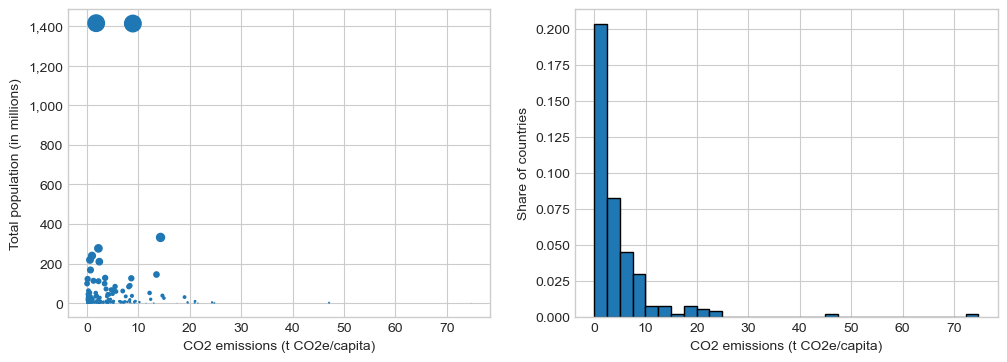

In [35]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))

# Scatter plot: total population vs per capita emissions
ax[0].scatter(
    df_co2['co2_pc'],
    df_co2['population'] / 1000000,
    s = df_co2['population'] / 10000000, # weight each country with its population
)
ax[0].set_xlabel('CO2 emissions (t CO2e/capita)')
ax[0].set_ylabel('Total population (in millions)')
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 

# Histogram of per capita emissions
ax[1].hist(df_co2['co2_pc'], bins = 30, density = True, edgecolor = 'black')
ax[1].set_xlabel('CO2 emissions (t CO2e/capita)')
ax[1].set_ylabel('Share of countries')

plt.show()

Conclusion: Yes, there seems to be some outliers in the data. These are countries that either have very high populations but low per capita CO2 emissions, or high per capita CO2 emissions but low populations.

In [36]:
# Countries with high per capita CO2 emissions (but low population)
df_co2[df_co2['co2_pc'] > 40]

,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel,co2_pc
189,Palau,2021,1.329,17783.0,81.483,13257.206321,100.0,9.347826,0.000000,0.9,East Asia & Pacific,High income,74.734297
200,Qatar,2021,117.966,2504910.0,99.278,71751.883126,100.0,6.440383,27.289787,0.0,"Middle East, North Africa, Afghanistan & Pakistan",High income,47.093908


In [37]:
# Countries with high population (but low per capita CO2 emissions)
df_co2[df_co2['population'] > 400*1000000]

,country,year,co2_total,population,urban,gdp_pc,electricity,agriculture,nat_resources,renew_energy,region,incomeLevel,co2_pc
46,China,2021,12621.6147,1.412360e+09,62.512,12887.435724,100.0,55.442624,1.707565,15.2,East Asia & Pacific,Upper middle income,8.936542
111,India,2021,2548.4833,1.414204e+09,35.393,2239.613844,99.6,60.050765,3.159345,34.9,South Asia,Lower middle income,1.802062


2. Create a figure with 6 subplots (either 2x3 or 3x2):
    - In each subplot, show a scatter plot of per capita CO2 emissions (`co2_pc`) and one of the potential explanatory variables of emissions (`urban`, `gdp_pc`, `electricity`, `agriculture`, `nat_resources`, `renew_energy`).
    - Add the correlation coefficient between the explanatory variable and per capita CO2 emissions in the  title of the subplot.

   *Hint*: To avoid using a nested `for` loop to generate the 2x3 or 3x2 plot, you can apply the `flatten` method on the `ax` object to create a one-dimensional object that you can use a single `for` loop to iterate over.

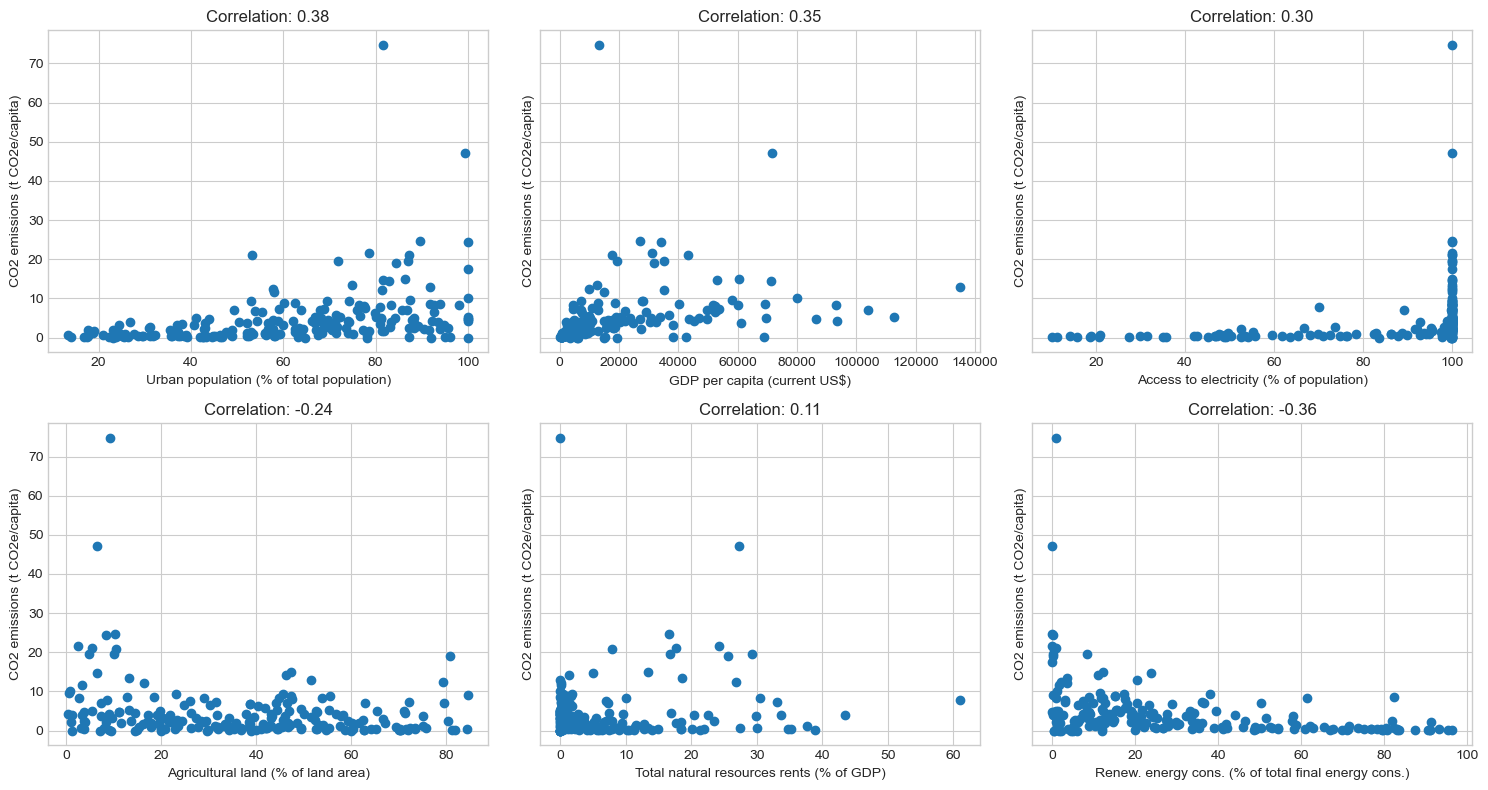

In [38]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharey = True, figsize = (15, 8))

# Flatten axes to one-dimensional object
fax = ax.flatten()

# Define explanatory variables and dict to use for nicer labels
xvars = ['urban', 'gdp_pc', 'electricity', 'agriculture', 'nat_resources', 'renew_energy']
d = {
    'urban' : 'Urban population (% of total population)',
    'gdp_pc' : 'GDP per capita (current US$)',
    'electricity' : 'Access to electricity (% of population)',
    'agriculture' : 'Agricultural land (% of land area)',
    'nat_resources' : 'Total natural resources rents (% of GDP)',
    'renew_energy' : 'Renew. energy cons. (% of total final energy cons.)'
}

for i in range(len(xvars)):

    # Define variable to place on x-axis
    xvar = xvars[i]

    # Scatter plot between per capita CO2 emissions and xvar
    fax[i].scatter(df_co2[xvar], df_co2['co2_pc'])

    # Formatting
    fax[i].set_ylabel('CO2 emissions (t CO2e/capita)')
    fax[i].set_xlabel(d[xvar])
    fax[i].set_title(f'Correlation: {df_co2['co2_pc'].corr(df_co2[xvar]):.2f}')

plt.tight_layout() # improve spacing between subplots
plt.show()

**Task 3**: You will now estimate a multiple linear regression model where per-capita CO2 emissions (`co2_pc`) is the depdenent variable, and the model includes three out of the six potential explanatory variables: `urban`, `gdp_pc`, `electricity`, `agriculture`, `nat_resources`, `renew_energy`. 

*Note*: Do not include any polynomial terms in the model.

In general, there are 20 possible combinations when you can choose three explanatory variables from six different variables. Your task is to find the combination of three variables that has the highest adjusted R-squared. 

Write a `for` loop in which you loop over the 20 possible combinations of three explanatory variables. For each possible combination:
- Estimate the linear regression model: $co2\_pc_i = \alpha + \beta_1 \times X1_i + \beta_2 \times X2_i + \beta_3 \times X3_i$
- Extract the adjusted R-squared from the model

Which combination of explanatory variables has the highest adjusted R-squared?

*Hint*: The function `combinations` from `itertools` can be used to generate all possible combinations from a set of values (see [here](https://www.geeksforgeeks.org/python/python-itertools-combinations-function/)).

In [39]:
# List of possible explanatory variables
xvars = ['urban', 'gdp_pc', 'electricity', 'agriculture', 'nat_resources', 'renew_energy']

# Empty list to store combinations
combs = []

# Print and save each possible combination of 3 variables
for comb in combinations(xvars, 3):
    print(comb)
    combs.append(comb)
    
print(len(combs))

('urban', 'gdp_pc', 'electricity')
('urban', 'gdp_pc', 'agriculture')
('urban', 'gdp_pc', 'nat_resources')
('urban', 'gdp_pc', 'renew_energy')
('urban', 'electricity', 'agriculture')
('urban', 'electricity', 'nat_resources')
('urban', 'electricity', 'renew_energy')
('urban', 'agriculture', 'nat_resources')
('urban', 'agriculture', 'renew_energy')
('urban', 'nat_resources', 'renew_energy')
('gdp_pc', 'electricity', 'agriculture')
('gdp_pc', 'electricity', 'nat_resources')
('gdp_pc', 'electricity', 'renew_energy')
('gdp_pc', 'agriculture', 'nat_resources')
('gdp_pc', 'agriculture', 'renew_energy')
('gdp_pc', 'nat_resources', 'renew_energy')
('electricity', 'agriculture', 'nat_resources')
('electricity', 'agriculture', 'renew_energy')
('electricity', 'nat_resources', 'renew_energy')
('agriculture', 'nat_resources', 'renew_energy')
20


In [40]:
# Empty list to store adj. r-squared
rsqr_lst = []

for comb in combs:

    # Generate formula from each tuple
    formula = 'co2_pc ~ ' + comb[0] + ' + ' + comb[1] + ' + ' + comb[2]
    
    # Get adj. R-squared from linear regression model
    # (Re-use get_rsqr function from task 2)
    df_temp = df_co2.dropna(subset = ['co2_pc', comb[0], comb[1], comb[2]], axis = 0)
    rsqr = get_rsqr(df_temp, formula)    
    rsqr_lst.append(rsqr)
    
print(len(rsqr_lst))

20


In [41]:
# Find max adj. R-squared
max_r = max(rsqr_lst)

# Find index of max adj. r-sqr
index = rsqr_lst.index(max_r)

# Find combination of that index
comb = combs[index]

print('The combination of explanatory variables with highest adj. R-sqr.:', comb)
print('Adj. R-squared:', str(round(max_r, 3)))

The combination of explanatory variables with highest adj. R-sqr.: ('gdp_pc', 'nat_resources', 'renew_energy')
Adj. R-squared: 0.226
